# Establishing a Good Distance Between Flu Sequences

First we need to establish the meaning of a distance between Influenza sequences. We will look at a special subset of the data where we know roughly what the similarity/distance is bewtween a pair. 

## Jaccard with k-grams

We will run k-grams and bag of "words" on the sequences and cross validate and see if the ones who are similar match our domain knowledge/possible labels. This will tell us if we have a good representation.

In [1]:
import pickle
import gzip
import numpy as np
import pandas as pd
import numba
from collections import Counter
from itertools import product
from FASTA_parse import sequence

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn')

In [3]:
# read in the sequences
with gzip.open('influenza.fna.pklz', 'rb') as fin:
    fna = pickle.load(fin)

In [4]:
fna_meta, fna_seq = fna.get_dataframe()

There are several duplicate sequences so we will remove them because they are irrelevent. It does not matter which one we keep either.

In [5]:
fna_seq.drop_duplicates(subset='Sequence', inplace=True)

Now we need to define a way of tokenizing the sequences so that we can create a word count vector. We also need to generate a dictionary that hold all the possible "words".

We generate the vectors on a sample of the data of size 1000.

### Using a library
We will now use a library from sklearn that will accomplish the same thing, but it is vectorized. This means we can easily increase our sample from 1000 to 10000 or more. Then we will use a KMeans library to cluster them. If we want to use a different distance (e.g. cosine distance) we would have to implement our own clustering.

In [6]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(4,6), dtype=np.uint16)
X = vectorizer.fit_transform(fna_seq.sample(frac=.15, random_state=0).Sequence.tolist())
vectorizer.get_feature_names()[:4]

['aaaa', 'aaaaa', 'aaaaaa', 'aaaaac']

In [30]:
vectorizer.get_feature_names()[-4:-1]

['yyttaa', 'yyyg', 'yyygc']

In [35]:
len(vectorizer.get_feature_names())

37244

Note: We can also use a vector that has more than k-gram tokens, e.g. we can use $k=5,6$.

In [32]:
# the sequences have some characters that don't hold very much information so we filter them out entirely.
import re
idxs = np.full((len(vectorizer.get_feature_names())), True, dtype=np.bool)
for i,token in enumerate(vectorizer.get_feature_names()):
    if not re.match('^[actg]+$', token):
        idxs[i] = False
        
X = X.toarray()[:,idxs]
X.shape


(66183, 5376)

### KMeans
Now we will attempt to run KMeans on our now generated vectors. We will look at the cost and see where k should be. We will most likely need to do some dimensionality reduction to improve our performance.

In [36]:
# MiniBatchKMeans!!
inert = np.zeros(shape=(20-2))

for k in range(2,20):
    km = MiniBatchKMeans(k, max_iter=500, batch_size=1000)
    km.fit_predict(X)
    inert[k-2] = km.inertia_
    print(km.inertia_)
    
inert

359861696.2065812
321199864.09046954
297159479.90812314
277617415.3081571
258882283.692334
251311464.44498518
234936113.10546508
220205229.84910658
217817031.96959662
209018276.91098836
201028499.82410586
198286647.0691182
187754565.8918467
186460963.25356475
177620348.1046193
176330472.86116037
169609457.12991756
168133503.02559987


array([3.59861696e+08, 3.21199864e+08, 2.97159480e+08, 2.77617415e+08,
       2.58882284e+08, 2.51311464e+08, 2.34936113e+08, 2.20205230e+08,
       2.17817032e+08, 2.09018277e+08, 2.01028500e+08, 1.98286647e+08,
       1.87754566e+08, 1.86460963e+08, 1.77620348e+08, 1.76330473e+08,
       1.69609457e+08, 1.68133503e+08])

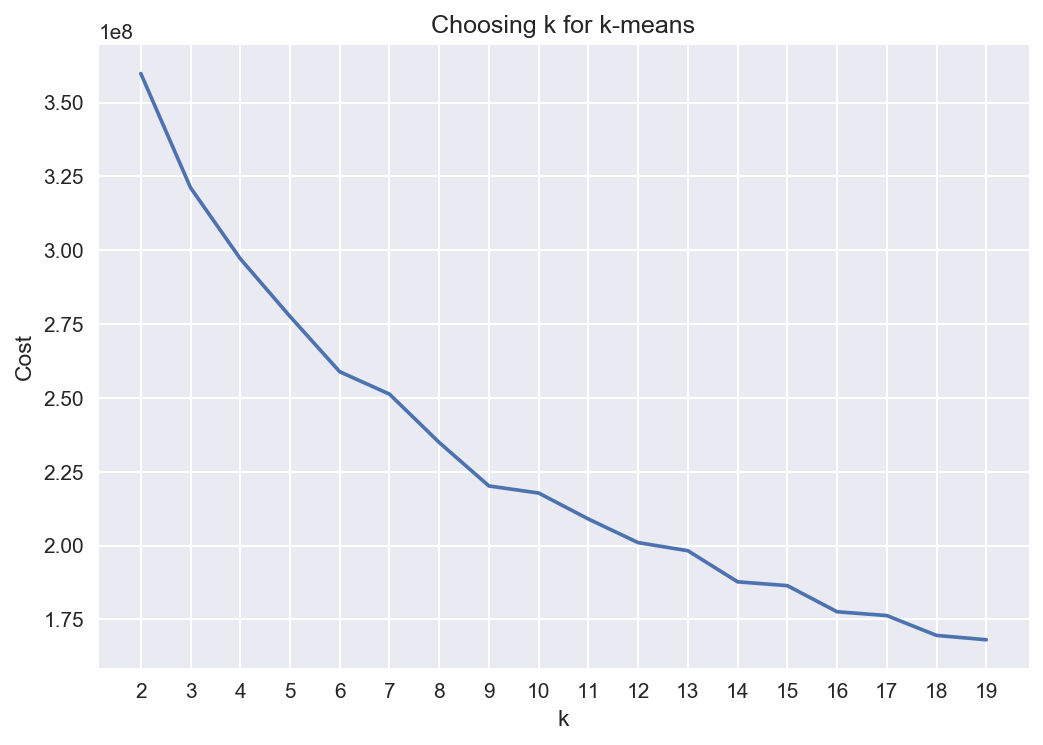

In [37]:
plt.plot(np.arange(2,20,1), inert)
plt.xticks(np.arange(2,20,1))
plt.title('Choosing k for k-means')
plt.xlabel('k')
plt.ylabel('Cost')
plt.show()

Since out KMeans cost was so high we will see if there are actually any clusters by using PCA. We will plot the 1st, 2nd, and 3rd PC's in a 2D plane.

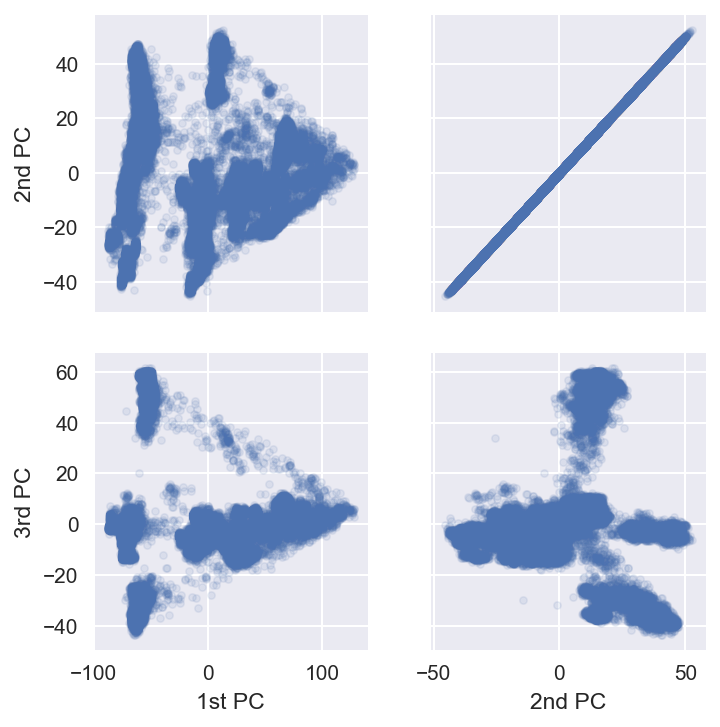

"\nfig, ax = plt.subplots(2,2)\nfig.subplots_adjust(wspace=0.15, hspace=0.3)\n\nax1 = ax[0,0]\nax1.scatter(new_X[:,0], new_X[:,1], alpha=.2)\nax1.set_xlabel('1st Principal Component')\nax1.set_ylabel('2nd Principal Component')\nax1.set_title('PCA')\n\nax2 = ax[0,1]\nax2.scatter(new_X[:,0], new_X[:,2], alpha=.2)\nax2.set_xlabel('1st Principal Component')\nax2.set_ylabel('3rd Principal Component')\nax2.set_title('PCA')\n\nax3 = ax[1,0]\nax3.scatter(new_X[:,1], new_X[:,2], alpha=.2)\nax3.set_xlabel('2nd Principal Component')\nax3.set_ylabel('3rd Principal Component')\nax3.set_title('PCA')\n\nax4 = ax[1,1]\nax4.hist(np.linalg.norm(new_X))\n\nplt.show()\n"

In [63]:
# TODO extract gene type and see if clusters correspond to the different genes
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
new_X = pca.fit_transform(X)

sns.pairplot(pd.DataFrame(new_X, columns=['1st PC', '2nd PC', '3rd PC']), markers='.', x_vars=['1st PC', '2nd PC'],
             y_vars=['2nd PC', '3rd PC'],
             plot_kws=dict(alpha=.1, edgecolor=None))
plt.show()

'''
fig, ax = plt.subplots(2,2)
fig.subplots_adjust(wspace=0.15, hspace=0.3)

ax1 = ax[0,0]
ax1.scatter(new_X[:,0], new_X[:,1], alpha=.2)
ax1.set_xlabel('1st Principal Component')
ax1.set_ylabel('2nd Principal Component')
ax1.set_title('PCA')

ax2 = ax[0,1]
ax2.scatter(new_X[:,0], new_X[:,2], alpha=.2)
ax2.set_xlabel('1st Principal Component')
ax2.set_ylabel('3rd Principal Component')
ax2.set_title('PCA')

ax3 = ax[1,0]
ax3.scatter(new_X[:,1], new_X[:,2], alpha=.2)
ax3.set_xlabel('2nd Principal Component')
ax3.set_ylabel('3rd Principal Component')
ax3.set_title('PCA')

ax4 = ax[1,1]
ax4.hist(np.linalg.norm(new_X))

plt.show()
'''

As we can see there are some very defined clusters. We should be able to approximate our sequence representations very well to a very low dimension. Note that we know there are 8 different gene types, so we expect there to be 8 clusters, but they may not be sharply defined.

### Using PCA to find the best lowest dimension representation
Now we will use PCA just like above to look at the first 10 components and see if it is clusterable. After we do that we will cross validate with some possible known cluster labels to see if our representations are representing the different genes or if it is a new structure.

In [23]:
pca = PCA(n_components=10)
new_X = pca.fit_transform(X)

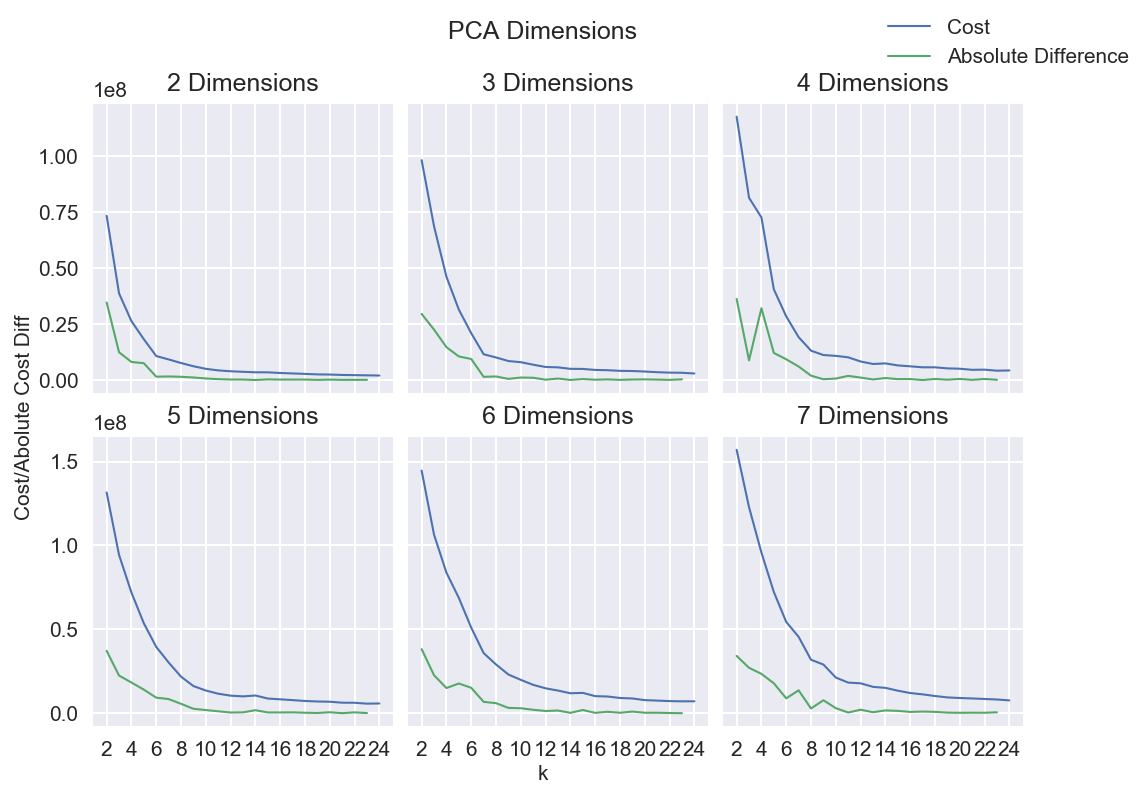

In [24]:
# MiniBatchKMeans!!
inerts = []
all_kms = []

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
fig.subplots_adjust(wspace=0.05, hspace=0.15)
i = -1
for n in range(2,8):
    if (n-2)%3 == 0:
        i +=1
        
    inert = []
    kms = []
    for k in range(2,25):
        km = MiniBatchKMeans(k, max_iter=550, batch_size=1000)
        km.fit_predict(new_X[:,:n])
        inert.append(km.inertia_)
        kms.append(km)
    
    all_kms.append(kms)
    curr = ax[i%2, (n-2)%3] 
    curr.plot(np.arange(2,25,1), inert, linewidth=1, label='Cost')
    curr.plot(np.arange(2,24,1), abs(np.diff(inert)), linewidth=1, label='Absolute Difference')
    curr.set_xticks(np.arange(2,25,2))
    curr.set_title('{} Dimensions'.format(n))
    

fig.text(0.5, 0.06, 'k', ha='center')
fig.text(0.06, 0.5, 'Cost/Abolute Cost Diff', va='center', rotation='vertical') 
fig.legend(['Cost', 'Absolute Difference'])
fig.suptitle('PCA Dimensions')
plt.show()

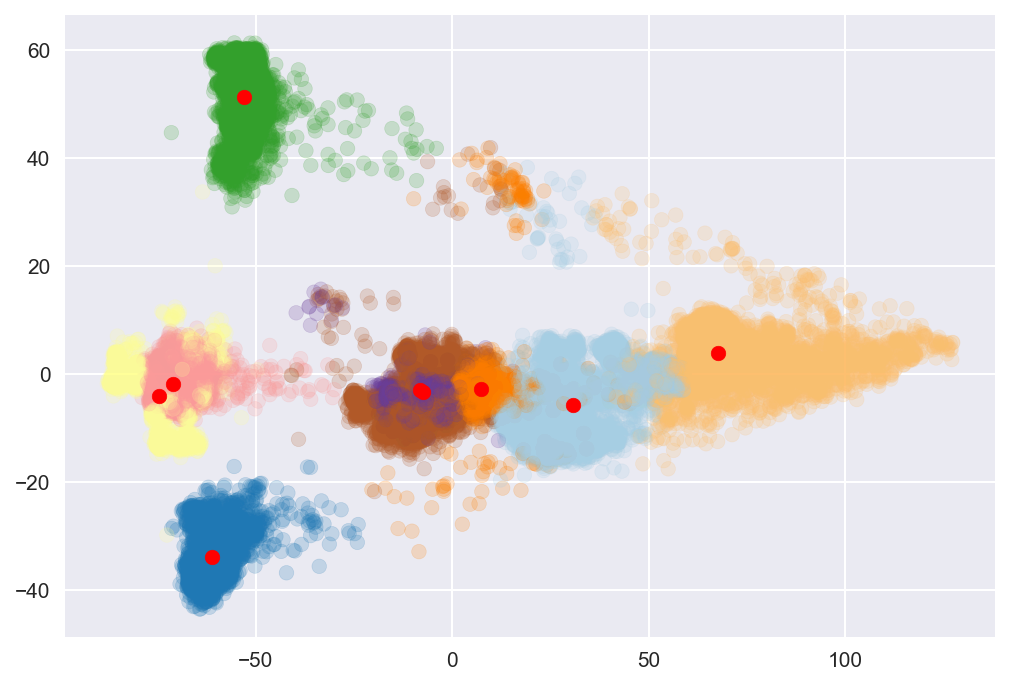

In [25]:
km7 = all_kms[2][7]

plt.scatter(new_X[:,0], new_X[:,2], alpha=.2, c=km7.labels_, cmap='Paired')
plt.scatter(km7.cluster_centers_[:,0], km7.cluster_centers_[:,2], c='r')
plt.show()